Practicing photometry on some archival images

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [189]:
path = '/media/david/2tb_ext_hd/hddata/trappist1_test/hst_phot/f275w/MAST_2023-05-26T22_23_06.370Z/HST/IEMQA1050/'

In [190]:
flcs = glob.glob('{}*flc.fits'.format(path))

In [191]:
flcs

['/media/david/2tb_ext_hd/hddata/trappist1_test/hst_phot/f275w/MAST_2023-05-26T22_23_06.370Z/HST/IEMQA1050/iemqa1n9q_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist1_test/hst_phot/f275w/MAST_2023-05-26T22_23_06.370Z/HST/IEMQA1050/iemqa1naq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist1_test/hst_phot/f275w/MAST_2023-05-26T22_23_06.370Z/HST/IEMQA1050/iemqa1niq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist1_test/hst_phot/f275w/MAST_2023-05-26T22_23_06.370Z/HST/IEMQA1050/iemqa1njq_flc.fits']

In [192]:
from photutils.aperture import CircularAnnulus, CircularAperture

In [251]:
data = fits.getdata(flcs[0], 1)

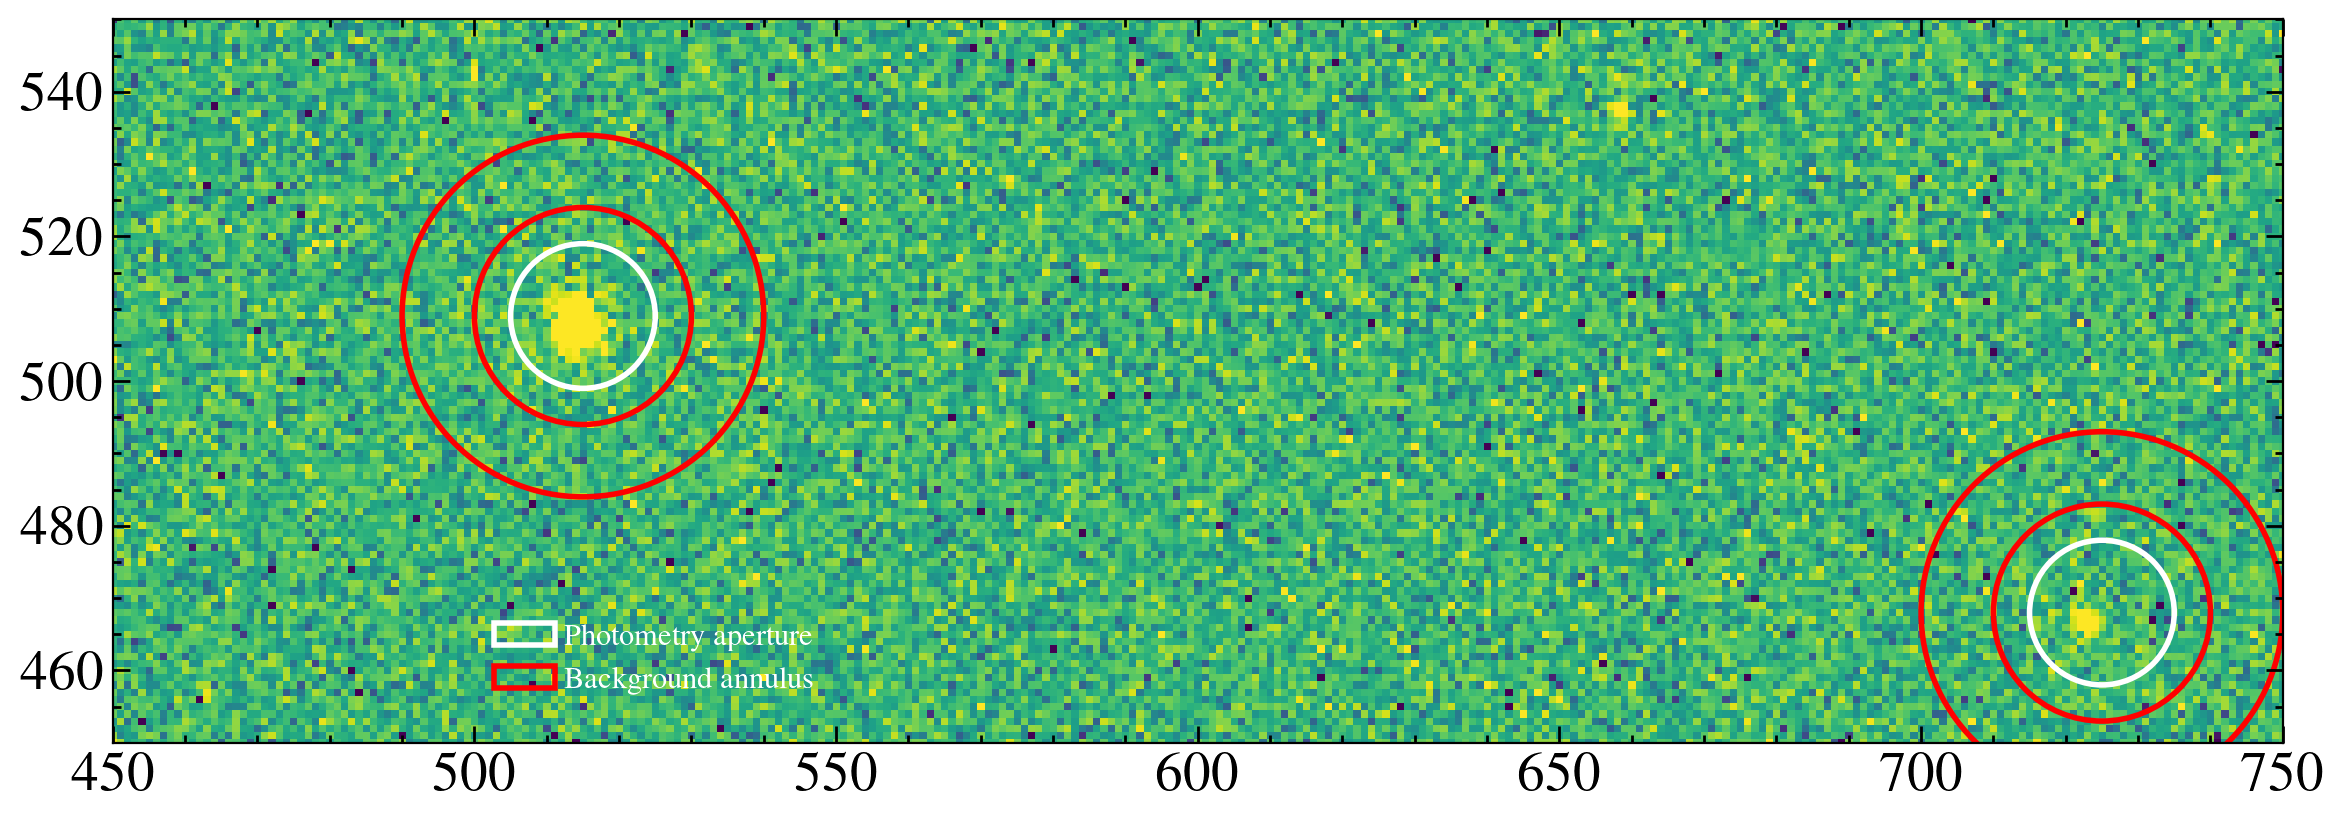

In [252]:
from astropy.visualization import simple_norm
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest')
plt.xlim(450, 750)
plt.ylim(450, 550)
positions = [(515, 509), (725, 468)]

aperture = CircularAperture(positions, r=10)

annulus_aperture = CircularAnnulus(positions, r_in=15, r_out=25)

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})

In [253]:
from photutils.aperture import ApertureStats

aperstats = ApertureStats(data, annulus_aperture)

bkg_mean = aperstats.mean

print(bkg_mean)  


[0.93441786 0.61038077]


In [254]:
from photutils.aperture import aperture_photometry

phot_table = aperture_photometry(data, aperture)

for col in phot_table.colnames:

    phot_table[col].info.format = '%.8g'  # for consistent table output

print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1     515     509    7742.0757
  2     725     468    839.97227


In [255]:
aperture_area = aperture.area_overlap(data)

print(aperture_area)  

[314.15926535897927, 314.15926535897927]


In [256]:
total_bkg = bkg_mean * aperture_area

print(total_bkg)  

[293.55602723 191.75677349]


In [257]:
phot_bkgsub = phot_table['aperture_sum'] - total_bkg

In [258]:
phot_table['total_bkg'] = total_bkg

phot_table['aperture_sum_bkgsub'] = phot_bkgsub

for col in phot_table.colnames:

    phot_table[col].info.format = '%.8g'  # for consistent table output

print(phot_table)

 id xcenter ycenter aperture_sum total_bkg aperture_sum_bkgsub
      pix     pix                                             
--- ------- ------- ------------ --------- -------------------
  1     515     509    7742.0757 293.55603           7448.5197
  2     725     468    839.97227 191.75677            648.2155


In [259]:
error = fits.getdata(flcs[0], 2)

In [260]:
phot_table = aperture_photometry(data, aperture, error=error)

for col in phot_table.colnames:

    phot_table[col].info.format = '%.8g'  # for consistent table output

print(phot_table)

 id xcenter ycenter aperture_sum aperture_sum_err
      pix     pix                                
--- ------- ------- ------------ ----------------
  1     515     509    7742.0757         109.0861
  2     725     468    839.97227        73.235481


In [261]:
phot_table['total_bkg'] = total_bkg

phot_table['aperture_sum_bkgsub'] = phot_bkgsub

for col in phot_table.colnames:

    phot_table[col].info.format = '%.8g'  # for consistent table output

print(phot_table)

 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     515     509    7742.0757         109.0861 293.55603           7448.5197
  2     725     468    839.97227        73.235481 191.75677            648.2155


Ok that works to get counts, now I convert it into flux with header keywords

In [262]:
hdr = fits.getheader(flcs[0], 0)
phtflam1 = hdr['PHTFLAM1']*u.erg/u.cm**2/u.AA
print(phtflam1)
exptime = hdr['EXPTIME']*u.s
print(exptime)

3.288796269479e-18 erg / (Angstrom cm2)
115.0 s


In [263]:
counts, counts_err= phot_table['aperture_sum_bkgsub'], phot_table['aperture_sum_err']

In [264]:
flux = counts*phtflam1/exptime
flux

<Quantity [2.13014467e-16, 1.85378149e-17] erg / (Angstrom cm2 s)>

That looks like a real number? Need to adjust for pixel area map. There's a notebook for that! https://github.com/spacetelescope/WFC3Library/blob/master/notebooks/uvis_pam_corrections/WFC3_UVIS_Pixel_Area_Map_Corrections_for_Subarrays.ipynb

In [265]:
from ginga.util.zscale import zscale

In [266]:
scihdr= fits.getheader(flcs[0], 1)

In [267]:


x0 = int(np.abs(scihdr['LTV1']))
y0 = int(np.abs(scihdr['LTV2']))
x1 = int(x0 + scihdr['NAXIS1'])
y1 = int(y0 + scihdr['NAXIS2'])

print (f'(x0, y0, x1, y1) = ({x0}, {y0}, {x1}, {y1})')


(x0, y0, x1, y1) = (0, 1, 1025, 1025)


In [268]:
pampath = '/media/david/2tb_ext_hd/hddata/trappist1_test/hst_phot/UVIS2wfc3_map.fits'
pamdata = fits.getdata(pampath)
pam = pamdata[y0:y1, x0:x1]

In [269]:
pamcorr_data = data * pam

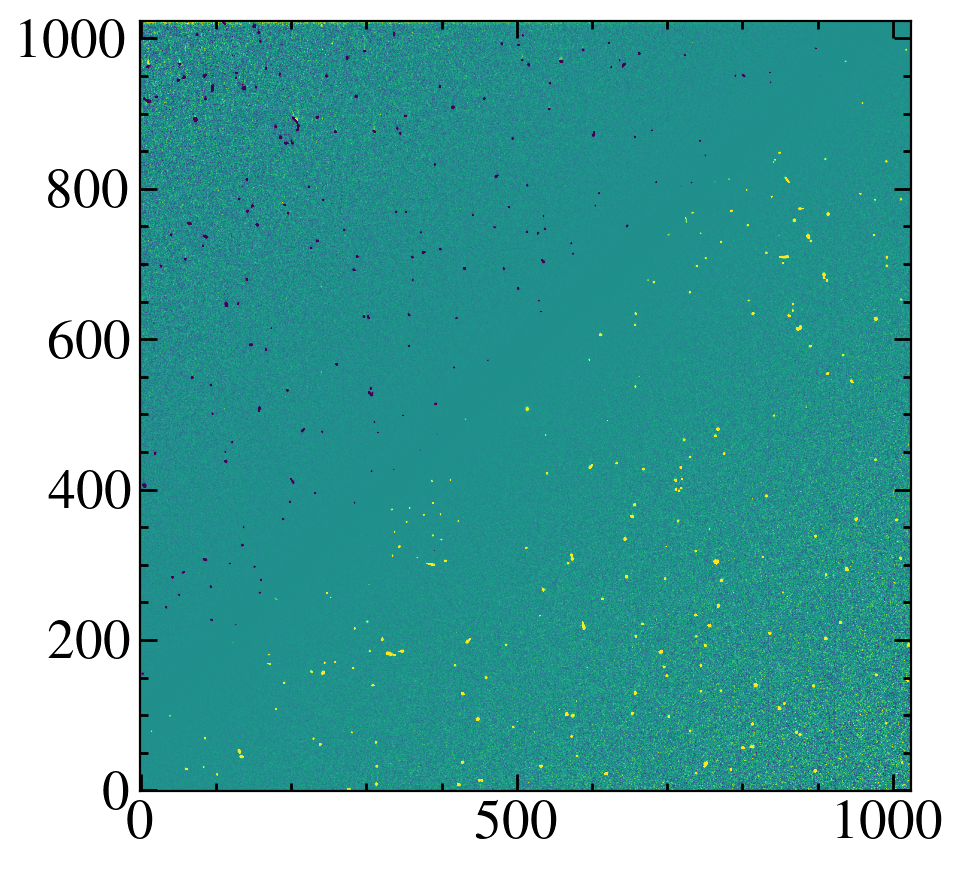

In [270]:
diff_data=(pamcorr_data-data)
vmin_diff, vmax_diff = zscale(diff_data)

plt.imshow(diff_data,vmin=vmin_diff,vmax=vmax_diff, origin='lower')


In [271]:
phot_table = aperture_photometry(pamcorr_data, aperture)
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,515.0,509.0,7747.104552859249
2,725.0,468.0,842.3436828513211


In [272]:
def make_PAMcorr_image_UVIS(data, scihdr, pamdir):
    """
    Corrects the geometric distortion of the input image
    data by multiplying by the correct UVIS PAM.
    Parameters
    ----------
    data : array
        Image data before correction.
    scihdr : header
        Header from science extension of data.
    pamdir : str
        Path to where pixel area maps for UVIS1 and/or
        UVIS2 are located.
    Returns
    -------
    pamcorr_data : array
        PAM-corrected data.
    """

    data = np.copy(data)
    x0 = int(np.abs(scihdr['LTV1']))
    y0 = int(np.abs(scihdr['LTV2']))
    x1 = int(x0 + scihdr['NAXIS1'])
    y1 = int(y0 + scihdr['NAXIS2'])
    

    if scihdr['CCDCHIP'] == 1:
        pam = fits.getdata(pamdir + 'UVIS1wfc3_map.fits')
        pamcorr_data = data * pam[y0:y1, x0:x1]

    elif scihdr['CCDCHIP'] == 2:
        pam = fits.getdata(pamdir + 'UVIS2wfc3_map.fits')
        pamcorr_data = data * pam[y0:y1, x0:x1]
    else:
        raise Exception('Chip case not handled.')

    return pamcorr_data

In [273]:
og = 7742.0757
new =7747.1046
print((og/new)*100)

99.9350867161391


Well I'm glad I did that. Aperture corrections? Think I need to check a 50 pixel aperture and see the difference?

In [274]:
bigap = CircularAperture(positions, r=50)

In [275]:
bigphot = aperture_photometry(pamcorr_data, bigap)
bigphot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,515.0,509.0,12520.758142110526
2,725.0,468.0,19342.808463508496


In [276]:
print(new/bigphot['aperture_sum'][0], 839.97227/bigphot['aperture_sum'][0])

0.6187408551519334 0.06708637452032218


In [277]:
big_area = bigap.area_overlap(pamcorr_data)
big_bkg = bkg_mean * big_area
print(big_bkg)
print(total_bkg)
bigphot_corr = bigphot['aperture_sum'] - big_bkg
print(bigphot_corr)

[7338.90068065 4793.91933731]
[293.55602723 191.75677349]
   aperture_sum  
-----------------
5181.857461458813
 14548.8891261942


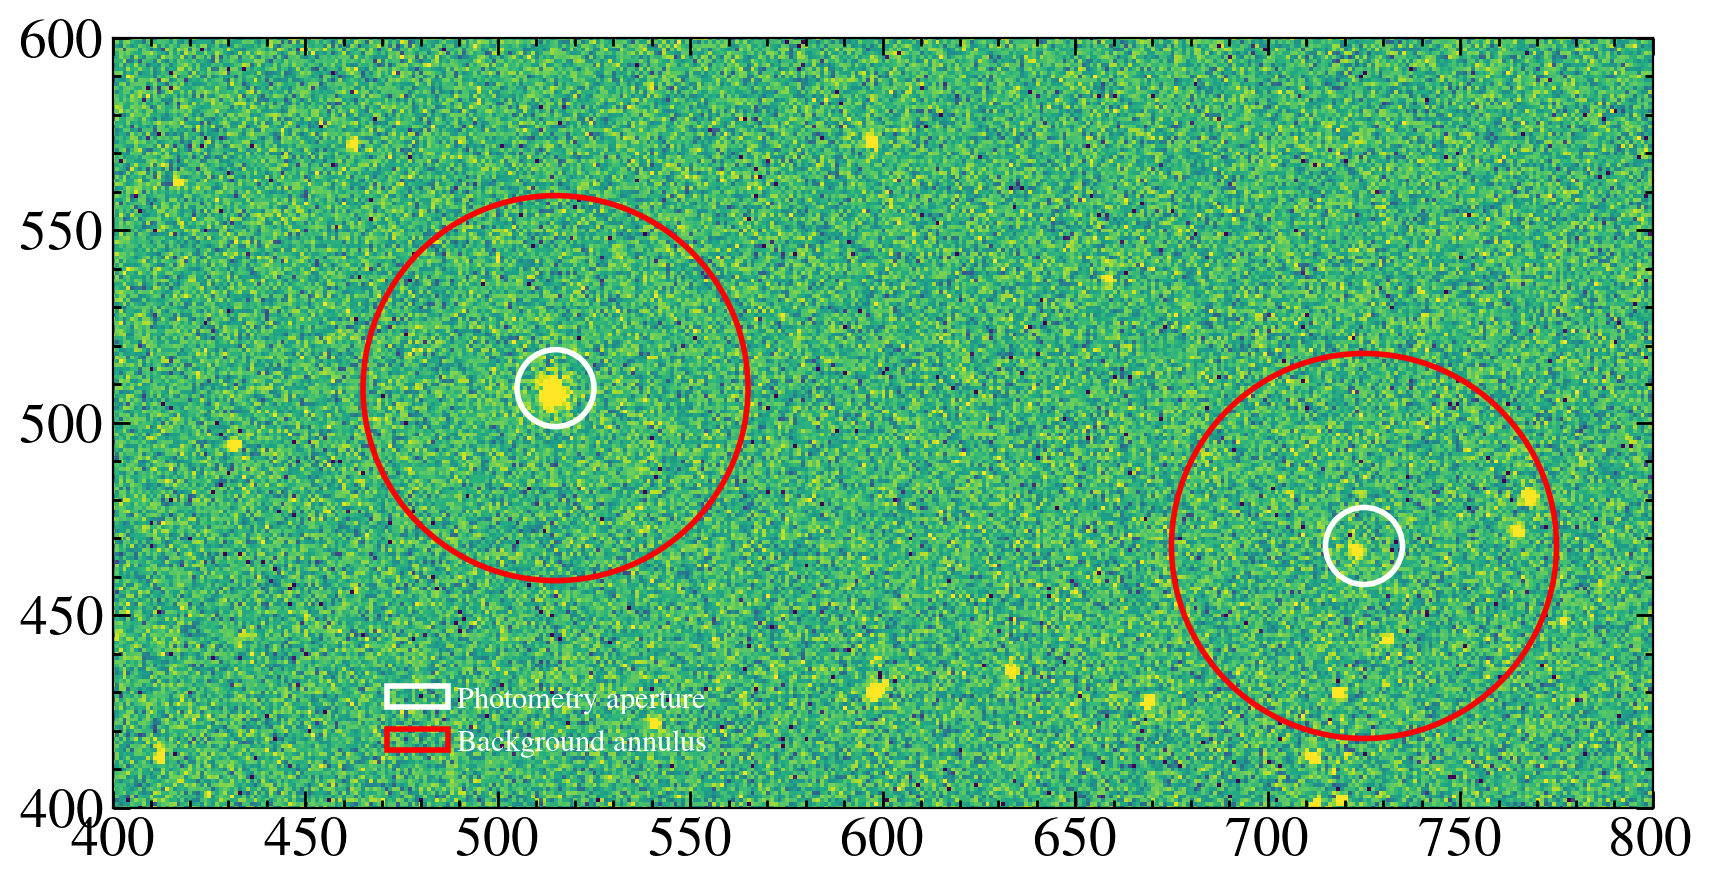

In [278]:
plt.imshow(pamcorr_data, norm=norm, interpolation='nearest')
plt.xlim(400, 800)
plt.ylim(400, 600)
positions = [(515, 509)]

# aperture = CircularAperture(positions, r=10)

# annulus_aperture = CircularAnnulus(positions, r_in=15, r_out=25)

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
# ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    # label='Background annulus')

ann_patches = bigap.plot(color='red', lw=2,
                                    label='Background annulus')

handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})

Getting aperture correction of 0.62, seems big? Try on another flc. Get 0.55 but there are bright cosmics

In [279]:
293*25

7325

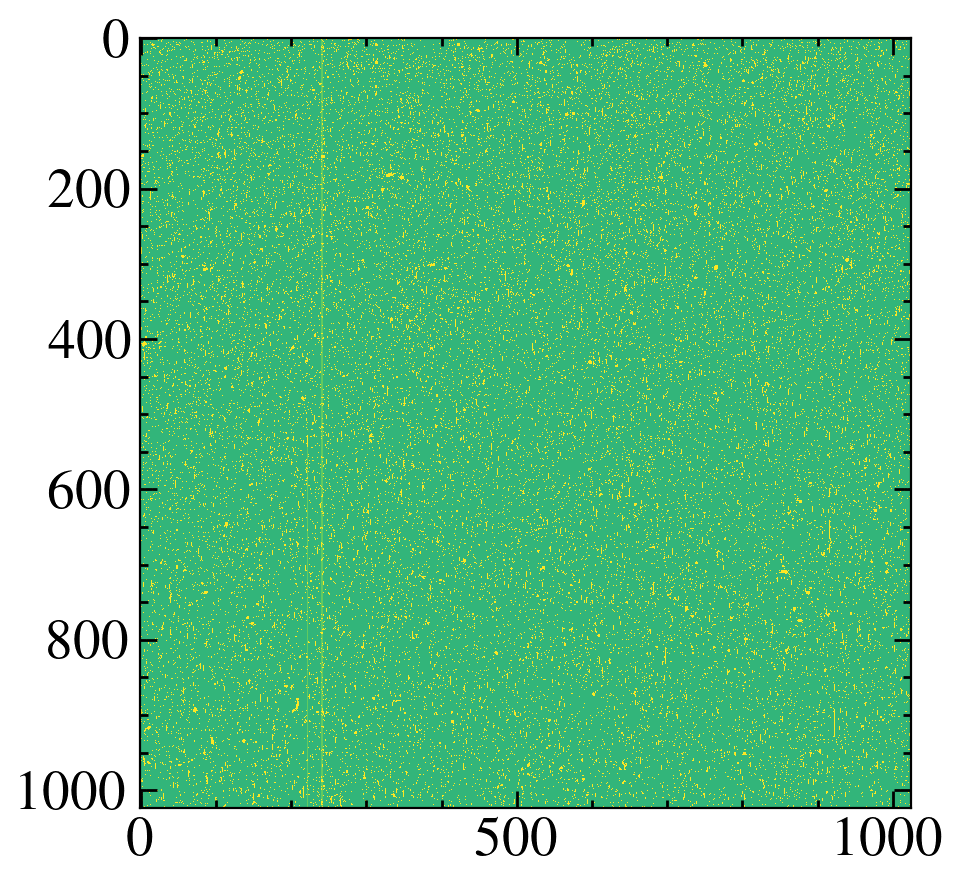

In [280]:
dq = fits.getdata(flcs[0], 3)
plt.imshow(dq, norm=norm, interpolation='nearest')